# SLS Sentinel 10m EN

Kode modelling klasifikasi densenet dan resnet IDM pada data sentinel 2 10m dengan neighbor Envelope, input tingkat SLS.

In [1]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,balanced_accuracy_score
import numpy as np

### SLS Dataset Review

In [3]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\AppData\Local\Temp\ipykernel_31020\701159028.py:1: DtypeWarning: Columns (19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")


In [4]:
sls.iddesa.unique().shape

(5957,)

In [5]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [6]:
sls_new = sls.set_index("iddesa").join(idm.set_index("bps_kelurahan_kode"), how ="left", rsuffix = "idm")

In [7]:
sls_new["iddesa"] = sls_new.index
sls_new["bps_kelurahan_kode"] = sls_new.index

In [8]:
sls_new.shape

(222861, 97)

In [9]:
sls_new = sls_new.drop_duplicates(["idsls"])

In [10]:
sls_new.shape

(219919, 97)

#### Preprocessing

In [11]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls sentinel 10m bound/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/06. SLS Sentinel 10m EN'

In [12]:
os.chdir(destpath)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [13]:
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].empty):
            if(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(sls_new.status[sls_new.bps_kelurahan_kode == int(name.replace(".jpg","")[:10])].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [15:57, 957.59s/it]


In [14]:
test_path = 'C:/Users/jwst2/Python/tesis/jpg/IDM/test sls 10m en/'

In [15]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/test_idm.csv")

In [16]:
split_test = split

In [17]:
os.chdir(test_path)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')

In [18]:
catlist = ["MAJU MANDIRI","TERTINGGAL BERKEMBANG"]

In [19]:
destpath + catlist[0]

'C:/Users/jwst2/Python/tesis/jpg/IDM/06. SLS Sentinel 10m ENMAJU MANDIRI'

In [20]:
for i in range(0,2):
    print(catlist[i])
    yourpath = destpath +"/"+ catlist[i]
    for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
        for name in files:
            try :
                if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                    shutil.move(os.path.join(root, name), test_path+catlist[i]+"/"+name)
            except Exception:
                print(name)
                pass 

MAJU MANDIRI


1it [00:44, 44.77s/it]


TERTINGGAL BERKEMBANG


1it [00:55, 55.71s/it]


### Run Dataset

In [21]:
path = Path.cwd() / (destpath)

In [22]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('MAJU MANDIRI'),Path('TERTINGGAL BERKEMBANG')]

In [23]:
fname = (path/"MAJU MANDIRI").ls()[0]
fname

Path('MAJU MANDIRI/32010200010001.jpg')

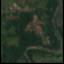

In [24]:
img = Image.open(fname)
img

In [25]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(64)) # data augmentation (mult multiplies the default transformation values)

In [26]:
dls = blocks.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


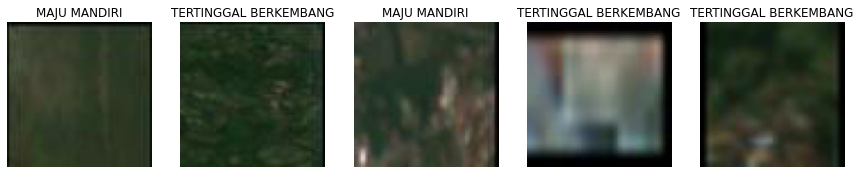

In [27]:
dls.show_batch(nrows=1, ncols=5)

In [28]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.00015848931798245758)

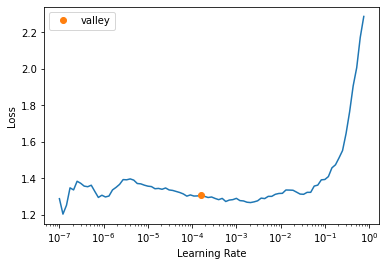

In [29]:
learn.lr_find()

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(7,lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.710550,2.436460,0.612757,0.576634,0.613327,0.576634,0.557262,0.653369,17:18
1,0.669315,0.792949,0.638871,0.612582,0.636679,0.612582,0.607528,0.663677,10:40
2,0.661432,0.690186,0.648193,0.620619,0.650074,0.620619,0.615012,0.677648,10:43
3,0.647075,0.639059,0.647363,0.626546,0.642361,0.626546,0.625417,0.678320,10:40
4,0.621047,0.677179,0.655280,0.639515,0.648859,0.639515,0.640214,0.687686,10:42
5,0.620456,1.425127,0.655791,0.633456,0.653396,0.633456,0.631914,0.691905,10:45
6,0.613729,0.717184,0.655472,0.634164,0.652129,0.634164,0.633118,0.693364,10:44


In [32]:
dls.vocab

['MAJU MANDIRI', 'TERTINGGAL BERKEMBANG']

In [33]:
dls.train.items[1500]

Path('TERTINGGAL BERKEMBANG/32110700150013.jpg')

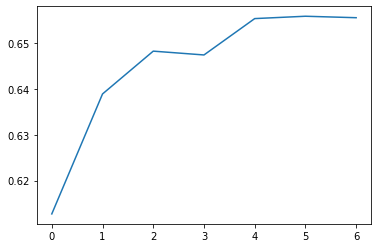

In [34]:
plt.plot(L(learn.recorder.values).itemgot(2));

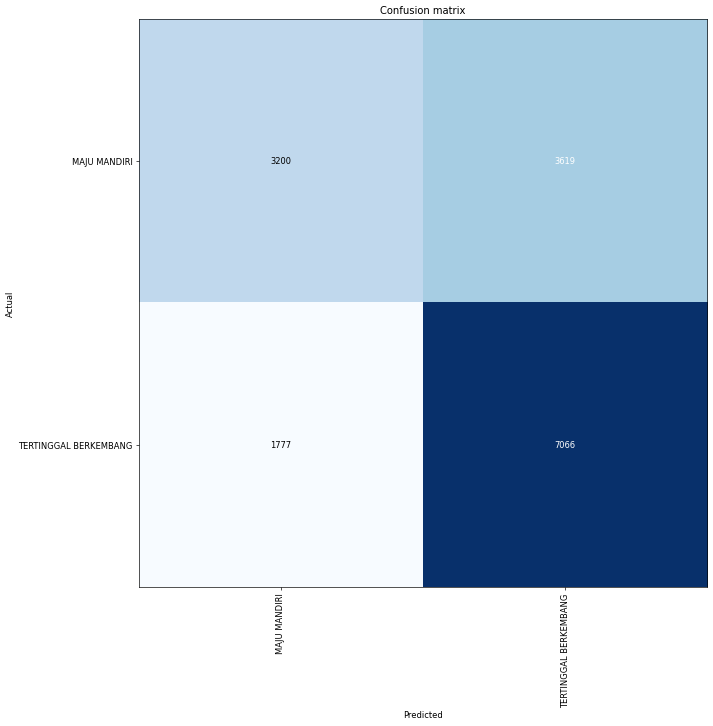

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(3, figsize=(20,11))

In [36]:
learn.export('C:/Users/jwst2/Python/tesis/models/SLS Densenet Sentinel EN.pkl')

### Up level

In [37]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if('TERTINGGAL BERKEMBANG' in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [38]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [39]:
pd.value_counts(true_label)

1    80145
0    60817
dtype: int64

In [40]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.426797,0.573203,32130600040003,1.0,3213060004
1,0.260615,0.739385,32101600020001,1.0,3210160002
2,0.828572,0.171428,32130310070017,0.0,3213031007
3,0.428413,0.571587,32021400100032,1.0,3202140010
4,0.120739,0.879261,32061400050035,1.0,3206140005


In [41]:
pd.value_counts(df.stat)

1.0    97718
0.0    43244
Name: stat, dtype: int64

In [42]:
df["true_lab"] = true_label

In [43]:
pd.value_counts(df.true_lab)

1    80145
0    60817
Name: true_lab, dtype: int64

In [44]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.660965366552688

In [45]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.426797,0.573203,32130600040003,1.0,3213060004,1
1,0.260615,0.739385,32101600020001,1.0,3210160002,0
2,0.828572,0.171428,32130310070017,0.0,3213031007,1
3,0.428413,0.571587,32021400100032,1.0,3202140010,0
4,0.120739,0.879261,32061400050035,1.0,3206140005,1


In [46]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [47]:
desa_pred.columns = ["pred","true"]

In [48]:
pd.value_counts(df.stat)

1.0    97718
0.0    43244
Name: stat, dtype: int64

In [49]:
for i in np.arange(0.0, 0.95, 0.05):
    value = round(i,3)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred >value,"label"+str(value)] = 1

In [50]:
desa_pred.head()

,pred,true,label0.0,label0.05,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,...,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,,,
3201010001,0.963636,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010003,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010004,0.977273,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3201010005,1.000000,1.0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [51]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.0
accuracy : 0.6442166910688141
precision : 0.6432637571157496
result label0.05
accuracy : 0.6544655929721815
precision : 0.6504273504273504
result label0.1
accuracy : 0.6655511399288851
precision : 0.6589771490750816
result label0.15
accuracy : 0.6739175904622464
precision : 0.665783079301966
result label0.2
accuracy : 0.6799832670989333
precision : 0.6719101123595506
result label0.25
accuracy : 0.6829115247856097
precision : 0.6763362265874828
result label0.3
accuracy : 0.6893955239489646
precision : 0.6830969541966985
result label0.35
accuracy : 0.6946245555323154
precision : 0.6894836570345808
result label0.4
accuracy : 0.6933695879523112
precision : 0.6934466019417476
result label0.45
accuracy : 0.6950428780589835
precision : 0.6986607142857143
result label0.5
accuracy : 0.698180297008994
precision : 0.7067246228586039
result label0.55
accuracy : 0.7023635222756746
precision : 0.7149986866298923
result label0.6
accuracy : 0.7015268772223384
precision : 0.723882643268

In [52]:
pd.value_counts(desa_pred.true)

1.0    3060
0.0    1721
Name: true, dtype: int64

### Test result

In [53]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [54]:
len(test_files)

17856

In [55]:
test_dl = learn.dls.test_dl(test_files)

In [56]:
preds,_ = learn.get_preds(dl  =test_dl)

In [57]:
str(test_files[1])[-18:-4]

'32010200170002'

In [58]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [59]:
test = pd.DataFrame(preds)

In [60]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [61]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [62]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.211738,0.788262,32010200170001,0,3201020017,1.0
1,0.240572,0.759428,32010200170002,0,3201020017,1.0
2,0.228077,0.771923,32010200170003,0,3201020017,1.0
3,0.573697,0.426303,32010200170004,0,3201020017,0.0
4,0.594585,0.405415,32010200170005,0,3201020017,0.0


In [63]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [64]:
desa_pred_test

,stat,true_lab
,mean,mean
iddesa,,
3201010011,0.777778,1.0
3201020002,0.857143,1.0
3201020017,0.325581,0.0
3201030009,0.979592,1.0
3201040009,0.750000,1.0
...,...,...
3218090012,1.000000,1.0
3218100001,1.000000,1.0


In [65]:
desa_pred_test.columns = ["pred","true"]

In [66]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.6,"pred_lab"] = 1

In [67]:
desa_pred_test

,pred,true,pred_lab
iddesa,,,
3201010011,0.777778,1.0,1
3201020002,0.857143,1.0,1
3201020017,0.325581,0.0,0
3201030009,0.979592,1.0,1
3201040009,0.750000,1.0,1
...,...,...,...
3218090012,1.000000,1.0,1
3218100001,1.000000,1.0,1
3218100004,1.000000,1.0,1


In [68]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.7156308851224106
balanced_accuracy_score : 0.6455128205128206
precision : 0.7463054187192119
recall : 0.8632478632478633
f1 : 0.8005284015852049
rocauc : 0.6455128205128206


### Resnet

In [69]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0003311311302240938)

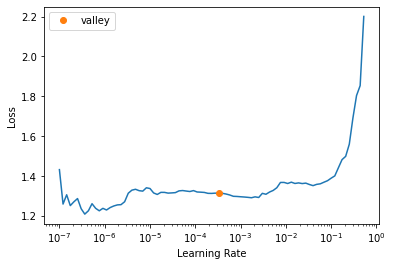

In [70]:
learn_rs.lr_find()

In [71]:
learn_rs.unfreeze()

In [72]:
learn_rs.fit_one_cycle(7,lr_max= 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.712050,0.675465,0.625144,0.589668,0.631094,0.589668,0.572567,0.661336,08:12
1,0.685875,0.674326,0.608032,0.591398,0.597580,0.591398,0.590811,0.631413,08:15
2,0.655467,0.655291,0.643085,0.619821,0.639085,0.619821,0.617183,0.669167,08:20
3,0.652633,0.637873,0.647874,0.625052,0.644429,0.625052,0.622894,0.677099,08:22
4,0.636680,0.660888,0.648448,0.622607,0.648161,0.622607,0.618444,0.672119,08:18
5,0.631936,0.629525,0.655919,0.635214,0.652175,0.635214,0.634457,0.687122,08:17
6,0.624994,0.626461,0.657451,0.634238,0.656245,0.634238,0.632289,0.690798,08:17


In [73]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/SLS resnet sentinel EN.pkl')

In [74]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
true_label = []
for i in dls.train.items:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [75]:
preds,_ = learn_rs.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

In [76]:
df = new_train
df["idsls"] = idx_train 
df["stat"] = round(df[1])
df["iddesa"] = df.idsls.str[:10]
df.head()

,0,1,idsls,stat,iddesa
0,0.377133,0.622867,32130600040003,1.0,3213060004
1,0.316252,0.683748,32101600020001,1.0,3210160002
2,0.809765,0.190235,32130310070017,0.0,3213031007
3,0.478805,0.521195,32021400100032,1.0,3202140010
4,0.222268,0.777732,32061400050035,1.0,3206140005


In [77]:
pd.value_counts(df.stat)

1.0    99808
0.0    41154
Name: stat, dtype: int64

In [78]:
df["true_lab"] = true_label

In [79]:
pd.value_counts(df.true_lab)

1    80145
0    60817
Name: true_lab, dtype: int64

In [80]:
accuracy_score(df.stat.apply(int),df.true_lab.apply(int))

0.6610079312155049

In [81]:
df.head()

,0,1,idsls,stat,iddesa,true_lab
0,0.377133,0.622867,32130600040003,1.0,3213060004,1
1,0.316252,0.683748,32101600020001,1.0,3210160002,0
2,0.809765,0.190235,32130310070017,0.0,3213031007,1
3,0.478805,0.521195,32021400100032,1.0,3202140010,0
4,0.222268,0.777732,32061400050035,1.0,3206140005,1


In [82]:
desa_pred = df.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [83]:
desa_pred.columns = ["pred","true"]

In [84]:
pd.value_counts(df.stat)

1.0    99808
0.0    41154
Name: stat, dtype: int64

In [85]:
for i in np.arange(0.1, 0.95, 0.05):
    value = round(i,2)
    desa_pred["label"+str(value)] = 0
    desa_pred.loc[desa_pred.pred > value,"label"+str(value)] = 1

In [86]:
desa_pred

,pred,true,label0.1,label0.15,label0.2,label0.25,label0.3,label0.35,label0.4,label0.45,label0.5,label0.55,label0.6,label0.65,label0.7,label0.75,label0.8,label0.85,label0.9
iddesa,,,,,,,,,,,,,,,,,,,
3201010001,1.000000,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010002,1.000000,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010003,1.000000,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010004,0.977273,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3201010005,0.968750,1.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279030007,1.000000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3279040001,0.980769,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3279040003,1.000000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [87]:
for j in range(2,19):
    print("result", desa_pred.columns[j])
    print("accuracy :",  accuracy_score( desa_pred.true,desa_pred.iloc[:,[j]]))
    print("precision :",  precision_score( desa_pred.true,desa_pred.iloc[:,[j]]))

result label0.1
accuracy : 0.6617862371888726
precision : 0.6558651976668827
result label0.15
accuracy : 0.6697343651955657
precision : 0.6626400175708325
result label0.2
accuracy : 0.6764275256222547
precision : 0.6687486058443007
result label0.25
accuracy : 0.6808199121522694
precision : 0.6734509271822705
result label0.3
accuracy : 0.6868855887889563
precision : 0.6797791580400276
result label0.35
accuracy : 0.691696297845639
precision : 0.6859756097560976
result label0.4
accuracy : 0.6921146203723071
precision : 0.6904076738609113
result label0.45
accuracy : 0.6935787492156452
precision : 0.6957055214723926
result label0.5
accuracy : 0.6960886843756536
precision : 0.7028528149457208
result label0.55
accuracy : 0.698389458272328
precision : 0.7095854922279793
result label0.6
accuracy : 0.7006902321690023
precision : 0.7188927707605482
result label0.65
accuracy : 0.7004810709056682
precision : 0.7261111111111112
result label0.7
accuracy : 0.6973436519556578
precision : 0.734925720943

### Test result resnet

In [88]:
path_pred = Path.cwd() / (test_path)
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]

In [89]:
test_dl = learn_rs.dls.test_dl(test_files)

In [90]:
preds,_ = learn_rs.get_preds(dl  =test_dl)

In [91]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
true_label = []
for i in test_files:
    if("TERTINGGAL BERKEMBANG" in str(i)) :
        true_label.append(1)
    else :
        true_label.append(0)

In [92]:
test = pd.DataFrame(preds)

In [93]:
test["idsls"] = idx_test
test["true_lab"] = true_label

In [94]:
test["iddesa"] = test.idsls.str[:10]
test["stat"] = round(test[1])

In [95]:
test.head()

,0,1,idsls,true_lab,iddesa,stat
0,0.247271,0.752729,32010200170001,0,3201020017,1.0
1,0.242939,0.757061,32010200170002,0,3201020017,1.0
2,0.233322,0.766677,32010200170003,0,3201020017,1.0
3,0.609272,0.390728,32010200170004,0,3201020017,0.0
4,0.519933,0.480067,32010200170005,0,3201020017,0.0


In [96]:
desa_pred_test = test.groupby('iddesa').agg({'stat': ['mean'], 'true_lab': 'mean'})

In [97]:
desa_pred_test.columns = ["pred","true"]

In [98]:
desa_pred_test["pred_lab"] = 0
desa_pred_test.loc[desa_pred_test.pred > 0.65,"pred_lab"] = 1

In [100]:
print("accuracy :",  accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("balanced_accuracy_score :",  balanced_accuracy_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("precision :",  precision_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("recall :",  recall_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("f1 :",  f1_score( desa_pred_test.true,desa_pred_test.pred_lab))
print("rocauc :",  roc_auc_score( desa_pred_test.true,desa_pred_test.pred_lab))

accuracy : 0.711864406779661
balanced_accuracy_score : 0.6480769230769231
precision : 0.75
recall : 0.8461538461538461
f1 : 0.7951807228915662
rocauc : 0.648076923076923


In [292]:
accuracy : 0.7099811676082862
balanced_accuracy_score : 0.6628917378917379
precision : 0.7654986522911051
recall : 0.8091168091168092
f1 : 0.7867036011080333
rocauc : 0.6628917378917378